In [1]:
import numpy as np
import numpy.testing as npt
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import poisson
import scipy.stats
import logging 

In [2]:
class JacksCarRentalEnvironment:
    
    def __init__(self):

        self.REQUEST_RATE = (3., 4.)      
        self.RETURN_RATE  = (3., 2.)

        self.GAMMA = 0.9   # 
        self.RENTAL_INCOME = 10
        self.TRANSFER_COST = 2
        self.TRANSFER_MAX  = 5
        self.MAX_CAPACITY  = 20 

        # location indicies
        self.A = 0
        self.B = 1
        self.state = np.array([0, 0])
        
    def reset(self,cars=10):
        self.state = np.array([cars,cars])
        return self.state
    
    def _nightly_moves(self, state, action):
        
        cars_at_A = state[0]
        cars_at_B = state[1]
        if action > 0:
            cars_moved = min(action, cars_at_A)
        else:
            cars_moved = max(action, -cars_at_B)
        
        cars_at_A = min(cars_at_A - cars_moved, self.MAX_CAPACITY)
        cars_at_B = min(cars_at_B + cars_moved, self.MAX_CAPACITY)
        return [cars_at_A, cars_at_B]
        

    
    def step(self,action):

        done = False
        info = ''
        state = self._nightly_moves(self.state, action)
        
        # random rents A per day
        rents_a = np.random.poisson(self.REQUEST_RATE[0])

        # random returns A per day
        returns_a = np.random.poisson(self.RETURN_RATE[0])

        # random rents B per day
        rents_b = np.random.poisson(self.REQUEST_RATE[1])

        # random returns B per day
        returns_b = np.random.poisson(self.RETURN_RATE[1])
    
        moving_costs = action * self.TRANSFER_COST
        
        
        # only renting available cars from A
        if rents_a > state[0]:
            info = "not enough cars at location A"
            done = True

        cars_to_rent_from_a = np.minimum(state[0], rents_a)
        state[0] = state[0] - cars_to_rent_from_a

        # only renting available cars from B
        if rents_b > state[1]:
            info = "not enough cars at location B"
            done = True

        cars_to_rent_from_b = np.minimum(state[1], rents_b)
        state[1] = state[1]- cars_to_rent_from_b

        # its getting evening, cars get returned
        self.state[0] = state[0] + returns_a
        self.state[1] = state[1] + returns_b
        renting_rewards = (cars_to_rent_from_a + cars_to_rent_from_b) * self.RENTAL_INCOME

        reward = renting_rewards - moving_costs

        return self.state, reward, done, info
        

In [3]:
env = JacksCarRentalEnvironment()
env.reset()
print(env.state)

[10 10]


In [4]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
env.step(-5)

(array([14,  0]), 70, True, 'not enough cars at location B')

In [5]:
env.reset() 
# the state is now [0, 0]
env.step(-5)

(array([15,  2]), 80, True, 'not enough cars at location B')

In [6]:
import unittest
class TestJacksCarRentalEnvironment(unittest.TestCase):
    # there are a lot of magic numbers in this test
    # these numbers depending on the env parameters!
    
    def setUp(self):
        self.env = JacksCarRentalEnvironment()
        
    def _avg_mean(self, cars, action, t_mean, max_diff=1.):
        env = self.env
        n = 10000
        r_mean = 0
        for i in range(n):
            env.reset(cars)
            _, r, _,_ = env.step(action)
            r_mean += r
        r_mean = r_mean / n
        diff = np.abs(r_mean - t_mean)
        self.assertTrue(diff < max_diff)
    
    def test_rent0(self):
        self._avg_mean(20, 0, 70)
        
    def test_rent1(self):
        self._avg_mean(10, 0, 70)    
        
    def test_nightly_moves(self):
        env.reset(0)
        _, r, _,_ = env.step(5)
        self.assertTrue(r==-10.)
        
    def _avg_nb_cars(self, a_desired, b_desired, 
                     cars, action):
        
        env = self.env
        n = 10000
        a_mean = 0
        b_mean = 0
        for i in range(n):
            env.reset(cars)
            ab, _, _,_ = env.step(action)
            a_mean += ab[0]
            b_mean += ab[1]
        a_diff = np.abs((a_mean / n) - a_desired)
        b_diff = np.abs((b_mean / n) - b_desired)
        self.assertTrue(a_diff < 0.5)
        self.assertTrue(b_diff < 0.5)
    
    def test_nb_cars_10_0(self):
        a_desired = 10
        b_desired = 8 
        cars = 10
        action = 0
        self._avg_nb_cars(a_desired, b_desired, 
                     cars, action)
        
    def test_nb_cars_10_3(self):
        a_desired = 7
        b_desired = 11 
        cars = 10
        action = 3
        self._avg_nb_cars(a_desired, b_desired, 
                     cars, action)
        
    def test_nb_cars_10_m2(self):
        a_desired = 12
        b_desired = 6 
        cars = 10
        action = -2
        self._avg_nb_cars(a_desired, b_desired, 
                     cars, action)

In [7]:
unittest.main(argv=['first-arg-is-ignored'], exit=False)

......
----------------------------------------------------------------------
Ran 6 tests in 2.172s

OK


In [8]:
class JacksCarRentalEnvironmentModel(JacksCarRentalEnvironment):
    
    def get_transition_probabilities_and_expected_reward(self, state, action):
        """
            Compute the $p(s', r\mid s,a)$
            Parameters
            ----------
            old_state: tuple of two ints
                the state (cars_at_A, cars_at_B)
            action: int
                nigthly movements of the cars as a int between -5 to 5, e.g.: 
                action +3: move three cars from A to B. 
                action -2: move two cars from B to A.
                
            Returns
            -------
            numpy array (2d - float): mapping from (new) states to probabilities
                index first dimension: cars at A
                index second dimension: cars at B
                value: probability  
            float:  expected reward for the state-action pair
        """
        #assert type(action) == int
        assert np.abs(action) <=5
        # first we move the cars in the night
        num_states_for_a_location = self.MAX_CAPACITY + 1
            
        state = self._nightly_moves(state, action)
    
        expected_reward = - self.TRANSFER_COST * np.abs(action)
        expected_reward += self._expected_reward_rent(state)
        
        transition_probabilities = self._rent_transition_probabilities(state)
        transition_probabilities = self._returns_transition_probabilities(transition_probabilities)
        return transition_probabilities, expected_reward  
        
        
    def _expected_reward_rent(self, state):
        expected_reward_rent = 0.
        m = self.MAX_CAPACITY+1
        request_mu = self.REQUEST_RATE
        for i in (0,1):
            cars_at_loc = state[i]
            rv = scipy.stats.poisson(request_mu[i])
            rent_prob = (rv.pmf(range(m)))
            logger.debug(rent_prob)
            rent_prob[cars_at_loc] = rent_prob[cars_at_loc:].sum()
            rent_prob[cars_at_loc+1:] = 0. 
            logger.debug(rent_prob)
            expected_reward_rent += np.dot(np.arange(len(rent_prob)), rent_prob) * self.RENTAL_INCOME
        return expected_reward_rent
        
    def _rent_transition_probabilities(self, state):
        
        num_states_for_a_location = self.MAX_CAPACITY + 1
        m = 15
        n = num_states_for_a_location + 2*m
        p_  = [np.zeros(n), np.zeros(n)]
        request_mu = self.REQUEST_RATE
        
        for i in (0,1):
            rv = scipy.stats.poisson(request_mu[i])
            cars_at_loc = state[i]
            x = cars_at_loc + m + 1     
            rent_prob = (rv.pmf(range(x)))
            assert state[i]-x+m+1 == 0
            p_[i][0:cars_at_loc+m+1] = rent_prob[::-1]
            p_[i][m] = p_[i][:m+1].sum()
            p_[i] = p_[i][m:-m]
        return p_
    
    def _returns_transition_probabilities(self, state_probalility):
        
        num_states_for_a_location = self.MAX_CAPACITY + 1
        m=11
        n = num_states_for_a_location + 2*m
        returns_mu = self.RETURN_RATE
        p_  = [np.zeros(num_states_for_a_location), np.zeros(num_states_for_a_location)]
        for i in (0,1):
            rv = scipy.stats.poisson(returns_mu[i])
            logger.debug(len(state_probalility[i]))
            for cars_at_loc in range(len(state_probalility[i])):
                p = np.zeros(n)
                logger.debug(p.shape)
                x = num_states_for_a_location - cars_at_loc + m - 1     
                return_prob = (rv.pmf(range(x)))
                logger.debug (p[cars_at_loc+m:-1].shape)
                p[cars_at_loc+m:-1] = return_prob
                logger.debug(return_prob)
                p[num_states_for_a_location+m-1] = p[num_states_for_a_location+m-1:].sum()
                p = p[m:-m]
                logger.debug(p)
                logger.debug(p.sum())
                p_[i] += p * state_probalility[i][cars_at_loc]
        return p_
    


In [9]:
jackModel = JacksCarRentalEnvironmentModel()

In [10]:
states = []
for i in range(0, 20 + 1):
    for j in range(0, 20 + 1):
        states.append([i, j])

In [11]:

actions = np.arange(-5, 6)
gamma=0.9
pi = np.random.randint(0, 1, len(states))



In [12]:
# compute values for each state/policy
def iterative_policy_evaluation_v(pi, gamma, states,V = np.zeros(len(states))):
    
    def computeStateValue(index,state):
        action = pi[index]
        transition_probabilities, expected_reward = jackModel.get_transition_probabilities_and_expected_reward(state=state, action=action)
        tp_a = transition_probabilities[0]
        tp_b = transition_probabilities[1]
        p_s_prime = np.dot(tp_a[:,None], tp_b[None]).ravel()
        return expected_reward + gamma * np.dot(p_s_prime,V)

    for i in range(0,5):
        V = np.array([computeStateValue(i,(s_a,s_b)) for i,(s_a, s_b) in enumerate(states)])
    
    return V

In [13]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def plot3d_over_states(f, zlabel="", ):
    MAX_CAPACITY = 20
    A = np.arange(0, MAX_CAPACITY+1)
    B = np.arange(0, MAX_CAPACITY+1)
    # B, A !!!
    B, A = np.meshgrid(B, A)
    V = f.reshape(MAX_CAPACITY+1,-1)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #ax = fig.gca(projection='3d')
    #surf = ax.plot_surface(A, B, V, rstride=1, cstride=1, cmap=cm.coolwarm,
    #                   linewidth=0, antialiased=False)
    #fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.scatter(A, B, V, c='b', marker='.')
    ax.set_xlabel("cars at A")
    ax.set_ylabel("cars at B")
    ax.set_zlabel(zlabel)
 
    #ax.view_init(elev=10., azim=10)
    
    plt.show()

In [14]:
def plot_policy(policy):
    MAX_CAPACITY = 20
    A = np.arange(0, MAX_CAPACITY+1)
    B = np.arange(0, MAX_CAPACITY+1)
    A, B = np.meshgrid(A, B)
    Po = policy.reshape(MAX_CAPACITY+1,-1)
    levels = range(0,11,1)
    plt.figure(figsize=(7,6))
    CS = plt.contourf(A, B, Po, levels)
    cbar = plt.colorbar(CS)
    cbar.ax.set_ylabel('actions')
    #plt.clabel(CS, inline=1, fontsize=10)
    plt.title('Policy')
    plt.xlabel("cars at B")
    plt.ylabel("cars at A")
    plt.show()

In [15]:
V = iterative_policy_evaluation_v(pi, gamma, states)

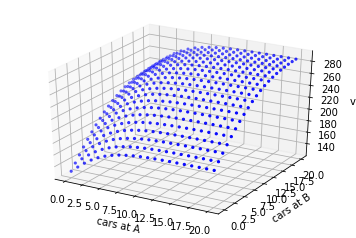

In [16]:
plot3d_over_states(V, 'v')

In [17]:
def iterative_policy_evaluation_q(pi, Q=np.zeros((len(states), len(actions)))):
    
    def computeValueForAction(state,j,action):
        transition_probabilities, expected_reward = jackModel.get_transition_probabilities_and_expected_reward(state=state, action=action)
        tp_a = transition_probabilities[0]
        tp_b = transition_probabilities[1]
        p_s_prime = np.dot(tp_a[:,None], tp_b[None]).ravel()
        return expected_reward + gamma * np.dot(p_s_prime, V) # V & gamma is Gloabal variable
    
    def computeQualityValue(QValue):
        for i, (s_a, s_b) in enumerate(states):
            #V = new_Q[states, pi]
            #V = np.zeros(len(states))
            QValue[i] = [computeValueForAction((s_a, s_b),j,action) for j,action in enumerate(actions)]
        return QValue
    
    return computeQualityValue(Q)

In [18]:


Q = iterative_policy_evaluation_q(pi)



In [19]:
def policy_improvement(pi=np.random.randint(len(states)), Q=np.zeros((len(states), len(actions)))):
    policy_stable = False
    while not policy_stable:
        Q = iterative_policy_evaluation_q(pi, Q)
        # Q[:, 1:] : we don't want the bet 0$  action!
        new_pi = np.argmax(Q[:, 0:], axis=1) #+ 1 # +1 to get the correct action id, we start at index 1!
        #new_pi = random_argmax_axis1(Q[:,1:]) + 1
        if (new_pi==pi).all():
            policy_stable = True
        pi = new_pi
    return pi, Q


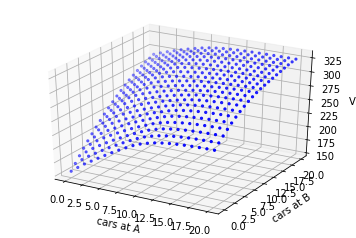

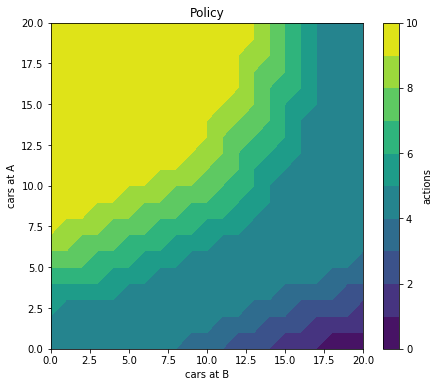

0


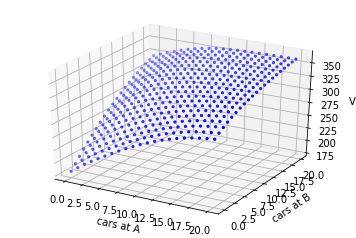

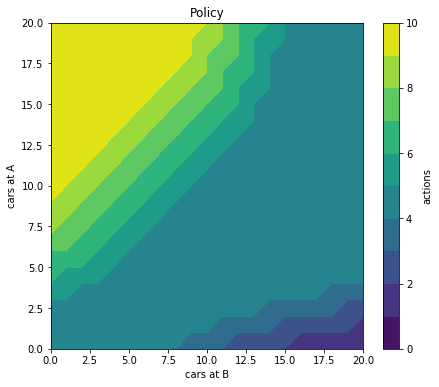

1


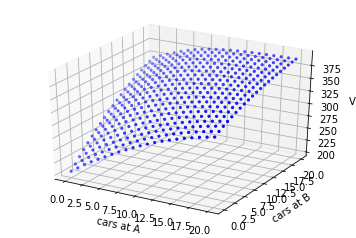

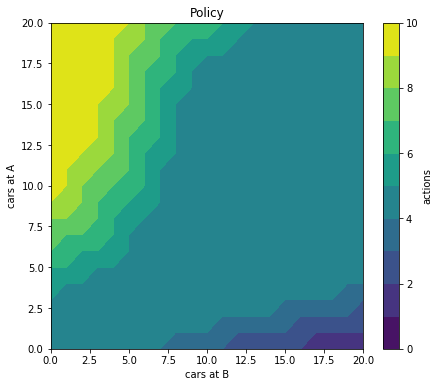

2


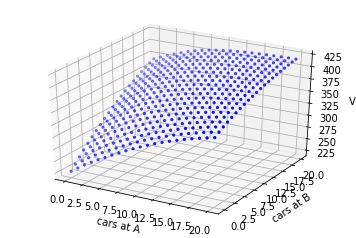

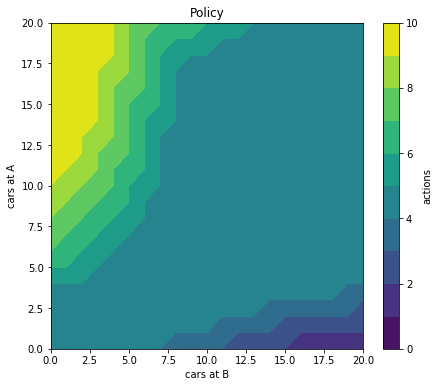

3


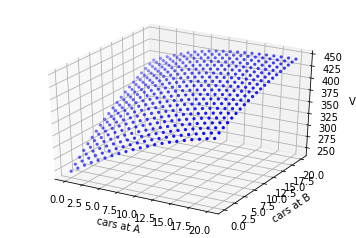

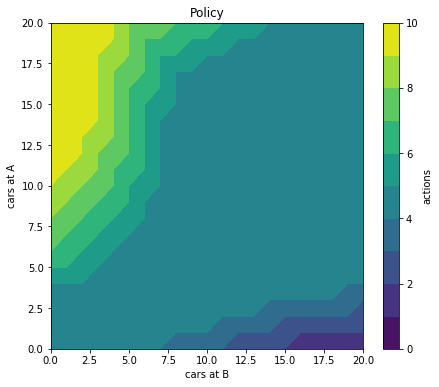

4


In [20]:
#watch the change
for i in range(0,5):
    pi, Q = policy_improvement(pi, Q)
    V = np.max(Q, axis=1)
    # V = np.sort(V)
    plot3d_over_states(V, 'V')
    plot_policy(pi)
    print(i)